# Final models fine-tunning


Tunning of best models found during comparison stage

In [53]:
import copy
import json
import os
import warnings
from ast import literal_eval
from itertools import product
from typing import Any, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score
from torcheval.metrics.functional.ranking import retrieval_precision
from tqdm import tqdm

In [54]:
MANUAL_SEED = 42
torch.manual_seed(MANUAL_SEED)

warnings.filterwarnings("ignore")

## Functions

### Data loading and preprocessing


In [55]:
def load_dataset(path: str) -> pd.DataFrame:
    loaded_dfs = [
        pd.read_csv(os.path.join(path, file_name)) for file_name in os.listdir(path)
    ]
    return pd.concat(loaded_dfs)


def load_datasets(path: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    return load_dataset(os.path.join(path, "train/")), load_dataset(
        os.path.join(path, "test/")
    )

In [56]:
NUM_MOVIES = 1682
BASIC_USER_FEATURES = 3

TOTAL_USER_FEATURES = BASIC_USER_FEATURES + 19

In [57]:
class RecommendationDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.drop(columns=["user_id"])
        features = []
        inputs = []
        targets = []
        for _, row in tqdm(df.iterrows(), total=len(df)):
            features.append(
                row[:BASIC_USER_FEATURES].tolist() + literal_eval(row["genres"])
            )
            inputs.append(literal_eval(row["input"]))
            targets.append(literal_eval(row["output"]))

        self.features = np.array(features)

        # normalize ratings
        self.inputs = np.array(inputs) / 5
        self.targets = np.array(targets) / 5

    def __getitem__(self, idx: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        input_ratings = self.inputs[idx]
        input_data = np.concatenate([self.features[idx], input_ratings])
        mask = input_ratings == 0
        return input_data, mask, self.targets[idx]

    def __len__(self) -> int:
        return len(self.df)

In [58]:
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


DEVICE

device(type='cuda')

In [59]:
def collate_batch(batch: list) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    input_data_batch, mask_batch, target_batch = [], [], []
    for input_data, mask, target in batch:
        input_data_batch.append(input_data)
        mask_batch.append(mask)
        target_batch.append(target)

    return (
        torch.Tensor(input_data_batch),
        torch.Tensor(mask_batch).bool(),
        torch.Tensor(target_batch),
    )

### Creating the network


In [60]:
INPUT_SIZE = TOTAL_USER_FEATURES + NUM_MOVIES


class RecSys(nn.Module):
    def __init__(
        self,
        hidden_dim1: int = 1024,
        hidden_dim2: int = 1024,
        hidden_dim3: int = 1024,
    ):
        super(RecSys, self).__init__()

        self.d1 = nn.Dropout(0.1)
        self.d2 = nn.Dropout(0.1)

        self.fc1 = nn.Linear(INPUT_SIZE, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, NUM_MOVIES)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.d1(x)
        x = F.relu(self.fc2(x))
        x = self.d2(x)
        x = F.relu(self.fc3(x))

        return F.sigmoid(self.fc4(x))

In [61]:
def create_model(load_path: Optional[str] = None) -> tuple[nn.Module, Any]:
    torch.manual_seed(MANUAL_SEED)
    if load_path is None:
        model = RecSys()

        for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    else:
        model = torch.load(load_path)
    model = model.to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, optimizer

### Train model


In [62]:
def train_one_epoch(
    model: nn.Module,
    loader,
    optimizer,
    loss_fn,
    epoch,
    use_mask: bool = True,
    loss_type: str = "BCE",
) -> float:
    model.train()
    train_loss = 0.0
    total = 0

    loop = tqdm(
        loader,
        total=len(loader),
        desc=f"Epoch {epoch}: train",
        leave=True,
    )
    for batch in loop:
        input_data, mask, target = batch
        input_data, target, mask = (
            input_data.to(DEVICE),
            target.to(DEVICE),
            mask.to(DEVICE),
        )

        # forward pass and loss calculation
        outputs = model(input_data)

        # zero the parameter gradients
        optimizer.zero_grad()

        relevant_targets = (target > 0).float() if loss_type == "BCE" else target

        if use_mask:
            loss = loss_fn(
                torch.masked_select(outputs, mask),
                torch.masked_select(relevant_targets, mask),
            )
        else:
            loss = loss_fn(outputs, relevant_targets)

        # backward pass
        loss.backward()
        total += target.shape[1]

        # optimizer run
        optimizer.step()

        train_loss += loss.item()
        loop.set_postfix({"loss": train_loss / total})
    return train_loss / total


def val_one_epoch(
    model: nn.Module,
    loader,
    loss_fn,
    epoch,
    use_mask: bool = True,
    loss_type: str = "BCE",
) -> float:
    loop = tqdm(
        loader,
        total=len(loader),
        desc=f"Epoch {epoch}: val",
        leave=True,
    )
    val_loss = 0.0
    total = 0
    with torch.no_grad():
        model.eval()  # evaluation mode
        for batch in loop:
            input_data, mask, target = batch
            input_data, target, mask = (
                input_data.to(DEVICE),
                target.to(DEVICE),
                mask.to(DEVICE),
            )

            outputs = model(input_data)

            relevant_targets = (target > 0).float() if loss_type == "BCE" else target

            if use_mask:
                loss = loss_fn(
                    torch.masked_select(outputs, mask),
                    torch.masked_select(relevant_targets, mask),
                )
            else:
                loss = loss_fn(outputs, relevant_targets)

            val_loss += loss.item()
            total += target.shape[1]
            loop.set_postfix({"loss": val_loss / total})
    return val_loss / total

In [63]:
def train_model(
    model: nn.Module,
    optimizer,
    loss_fn,
    train_dataloader,
    val_dataloader,
    save_best_path: str,
    save_latest_path: str,
    num_epochs: int,
    use_mask: bool = True,
    loss_type: str = "BCE",
) -> tuple[nn.Module, list[float], list[float]]:
    best_loss = 1e10
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(
            model,
            train_dataloader,
            optimizer,
            loss_fn,
            epoch,
            use_mask=use_mask,
            loss_type=loss_type,
        )
        val_loss = val_one_epoch(
            model, val_dataloader, loss_fn, epoch, use_mask=use_mask, loss_type=loss_type
        )
        if val_loss <= best_loss:
            best_loss = val_loss
            torch.save(model, save_best_path)

        train_losses.append(float(train_loss))
        val_losses.append(float(val_loss))
    torch.save(model, save_latest_path)

    return copy.deepcopy(model), train_losses, val_losses

### Test model


In [64]:
def get_single_output(
    model: nn.Module,
    input_data: np.ndarray,
) -> np.ndarray:
    with torch.no_grad():
        model.eval()
        input_tensor = torch.Tensor([input_data]).to(DEVICE)
        model_out = model(input_tensor)

    return model_out[0].cpu().numpy()

In [65]:
def load_genres(path: str) -> list[str]:
    return pd.read_csv(
        os.path.join(path, "u.genre"),
        sep="|",
        header=None,
        names=["name", "genre_idx"],
        encoding="ISO-8859-1",
    )["name"].tolist()


def load_items(path: str, genres: list[str]) -> pd.DataFrame:
    return pd.read_csv(
        os.path.join(path, "u.item"),
        sep="|",
        header=None,
        names=[
            "movie_id",
            "movie_title",
            "release_date",
            "video_release_date",
            "IMDb_URL",
            *genres,
        ],
        encoding="ISO-8859-1",
    )


genres = load_genres("../data/raw/ml-100k/")
movies_df = load_items("../data/raw/ml-100k/", genres)

In [66]:
NUM_GENRES = len(genres)

In [67]:
def get_unseen_on_input_data(
    input_rating: np.ndarray, movie_ratings: np.ndarray
) -> np.ndarray:
    unseen_ratings = movie_ratings.copy()
    seen_indices = np.nonzero(input_rating > 0)[0]
    unseen_ratings[seen_indices] = 0
    return unseen_ratings


def calculate_genre_ratios(
    movie_indices: np.ndarray, movie_ratings: np.ndarray, items_df: pd.DataFrame
) -> np.ndarray:
    ratios = np.zeros(NUM_GENRES)
    for movie_id, rating in zip(movie_indices + 1, movie_ratings):
        ratios += (
            items_df[items_df["movie_id"] == movie_id].iloc[:, 5:].to_numpy()[0] * rating
        )
    return ratios / (
        len(movie_indices) * 5.0
    )  # the best scenario - all watched have rating 5


def get_recommendations(
    model: nn.Module,
    encoded_age: float,
    encoded_gender: int,
    encoded_occupation: int,
    movie_indices: list[int],
    movies_df: pd.DataFrame,
    predicted_threshold: float,
    num_recs: int = 5,
) -> np.ndarray:
    movie_indices_shifted = np.array(movie_indices) - 1  # starting from 0

    movies_ratings = np.zeros(NUM_MOVIES)
    movies_ratings[movie_indices_shifted] = 1.0  # rating = 5
    watched_ratings = np.ones(len(movies_ratings)) * 5

    input_vector = np.array(
        [
            encoded_age,
            encoded_gender,
            encoded_occupation,
            *calculate_genre_ratios(
                np.array(movie_indices_shifted), watched_ratings, movies_df
            ),
            *movies_ratings,
        ]
    )

    predictions = get_single_output(model, input_vector)
    predictions[predictions < predicted_threshold] = 0.0
    unseen_predictions = get_unseen_on_input_data(movies_ratings, predictions)

    movie_ids = np.argsort(-unseen_predictions) + 1

    unknown_idx = 267  # actual idx (from 1)
    movie_ids = np.delete(movie_ids, np.where(movie_ids == unknown_idx))

    return movie_ids[:num_recs]


def get_movie_titles(
    recommended_movies: np.ndarray, movies_df: pd.DataFrame
) -> list[str]:
    return [
        movies_df[movies_df["movie_id"] == movie_id]["movie_title"].to_list()[0]
        for movie_id in recommended_movies
    ]


def show_recommendations(
    model: nn.Module,
    movies_set: list[tuple[str, list[int]]],
    predicted_threshold: float = 0.0,
):
    for movies_name, movies in movies_set:
        print(movies_name)
        recommended_movies = get_recommendations(
            model, 0.21, 1, 19, movies, movies_df, predicted_threshold
        )
        print(f"Recommendations: {get_movie_titles(recommended_movies, movies_df)}\n")

### Metrics

In [68]:
def generate_test_data(
    model: nn.Module, dataset: RecommendationDataset
) -> list[tuple[np.ndarray, np.ndarray]]:
    test_data = []

    for input_data, _, target in tqdm(dataset):
        predicted = get_single_output(model, input_data)

        input_ratings = input_data[TOTAL_USER_FEATURES:]
        unseen_predicted = get_unseen_on_input_data(input_ratings, predicted)
        unseen_target = get_unseen_on_input_data(input_ratings, target)
        test_data.append((unseen_target, unseen_predicted))

    return test_data

In [69]:
def get_top_args(x: np.ndarray, n: int) -> np.ndarray:
    return np.argsort(-x)[:n]


def top_intersection(target: np.ndarray, predicted: np.ndarray, top_n: int = 20):
    return list(
        set(get_top_args(target, top_n)).intersection(get_top_args(predicted, top_n))
    )


def top_k_intersections(
    data: list[tuple[np.ndarray, np.ndarray]], k: int, threshold: float = 0.0
) -> list[int]:
    intersections = []
    for unseen_target, unseen_predicted in data:
        nonzero_targets = unseen_target[unseen_target > threshold]
        relevant_predicted = unseen_predicted[unseen_predicted > threshold]
        intersections.append(
            len(top_intersection(nonzero_targets, relevant_predicted, k))
        )

    return intersections


def retrieval_precisions_on_k(
    data: list[tuple[np.ndarray, np.ndarray]], k: int, threshold: float = 0.0
) -> list[int]:
    retrieval_precisions = []
    for unseen_target, unseen_predicted in data:
        nonzero_targets = unseen_target > threshold
        relevant_predicted = unseen_predicted

        retrieval_precisions.append(
            retrieval_precision(
                torch.Tensor(relevant_predicted), torch.Tensor(nonzero_targets), k
            ).item()
        )

    return retrieval_precisions


def precision_scores(
    data: list[tuple[np.ndarray, np.ndarray]], threshold: float = 0.0
) -> list[int]:
    precisions = []
    for unseen_target, unseen_predicted in data:
        nonzero_targets = unseen_target > threshold
        relevant_predicted = unseen_predicted > threshold

        precisions.append(precision_score(relevant_predicted, nonzero_targets))

    return precisions


def recall_scores(
    data: list[tuple[np.ndarray, np.ndarray]], threshold: float = 0.0
) -> list[int]:
    recalls = []
    for unseen_target, unseen_predicted in data:
        nonzero_targets = unseen_target > threshold
        relevant_predicted = unseen_predicted > threshold

        recalls.append(recall_score(relevant_predicted, nonzero_targets))

    return recalls


def average_precision_on_k(target: np.ndarray, predicted: np.ndarray, k: int) -> float:
    relevant_predicted = predicted.copy()
    if len(relevant_predicted) > k:
        relevant_predicted = relevant_predicted[:k]

    score = 0.0
    hits = 0

    for idx, x in enumerate(relevant_predicted):
        if x in target and x not in relevant_predicted[:idx]:
            hits += 1
            score += hits / (idx + 1.0)

    return score / max(min(len(target), k), 1)


def map_on_k(
    targets: list[np.ndarray], predictions: list[np.ndarray], k: int
) -> tuple[float, list[float]]:
    average_precisions = [
        average_precision_on_k(target, predicted, k)
        for target, predicted in zip(targets, predictions)
    ]
    return np.mean(average_precisions), average_precisions


def generate_total_data_lists(
    data: list[tuple[np.ndarray, np.ndarray]], threshold: float = 0.0
) -> tuple[list[np.ndarray], list[np.ndarray]]:
    all_targets = []
    all_predictions = []
    for unseen_target, unseen_predicted in data:
        nonzero_targets = unseen_target > threshold
        all_targets.append(
            np.argsort(nonzero_targets)[len(nonzero_targets) - sum(nonzero_targets) :]
        )
        all_predictions.append(np.argsort(-unseen_predicted))

    return all_targets, all_predictions

In [70]:
def get_metrics_dict(
    data: list[tuple[np.ndarray, np.ndarray]], ks: list[int], threshold: float = 0.0
) -> dict:
    all_targets, all_predictions = generate_total_data_lists(data, threshold=threshold)
    precisions = precision_scores(data, threshold=threshold)
    recalls = recall_scores(data, threshold=threshold)
    metrics_dict: dict[str, Any] = {
        "global": {
            "mean_precision": float(np.mean(precisions)),
            "mean_recalls": float(np.mean(recalls)),
        }
    }
    for k in ks:
        intersections = top_k_intersections(data, k, threshold=threshold)
        retrieval_precisions = retrieval_precisions_on_k(data, k, threshold=threshold)
        map_score, average_precisions = map_on_k(all_targets, all_predictions, k)

        metrics_dict[str(k)] = {
            "mean_top_intersections": float(np.mean(intersections)),
            "mean_retrieval_precision": float(np.mean(retrieval_precisions)),
            "map": float(map_score),
            "average_precisions": average_precisions,
            "retrieval_precisions": retrieval_precisions,
            "intersections": intersections,
        }
    return metrics_dict

In [71]:
def show_dict_metrics(models_dict: dict, include_metrics: list[str]):
    for model_name, values in models_dict.items():
        metrics_dict = values["metrics"]
        print(f"{model_name.upper()}")
        for k_value, metrics in metrics_dict.items():
            if k_value == "global":
                continue
            print(f"K={k_value}")
            for k in include_metrics:
                print(f"{k}: {metrics[k]}")
        print()

## Models fine-tunning

In [72]:
def build_dataset(path: str) -> RecommendationDataset:
    df = load_dataset(path)
    return RecommendationDataset(df)


def build_datasets(path: str) -> tuple[RecommendationDataset, RecommendationDataset]:
    data_frames = load_datasets(path)
    return (
        RecommendationDataset(data_frames[0]),
        RecommendationDataset(data_frames[1]),
    )

In [73]:
NUM_EPOCHS = 15
METRICS_KS = [5, 10, 20, 50]


def start_fine_tunning(
    prefix: str, model_params_dict: dict, save_model_path: str = "../models/"
) -> dict:
    models_dict = {}
    prev_data_path = ""
    prev_data = (0, 0)

    for model_key_name, params_dict in model_params_dict.items():
        print(model_key_name.upper())
        load_model_path = params_dict["model_path"]
        data_path = params_dict["data_path"]
        loss_fn = params_dict["loss_fn"]
        loss_name = params_dict["loss_name"]
        loss_mask = params_dict["loss_mask"]

        model_name = f"{prefix}_{model_key_name}"

        # Data loading
        if data_path == prev_data_path:
            data = prev_data
        else:
            prev_data_path = data_path
            data = prev_data = build_datasets(data_path)

        train_dataset, val_dataset = data

        torch.cuda.empty_cache()
        train_dataloader = torch.utils.data.DataLoader(
            dataset=train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            collate_fn=collate_batch,
        )
        val_dataloader = torch.utils.data.DataLoader(
            dataset=val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            collate_fn=collate_batch,
        )

        # Train
        model_name_best = f"{model_name}_best"
        model_path_best = os.path.join(save_model_path, model_name_best)

        model_name_latest = f"{model_name}_latest"
        model_path_latest = os.path.join(save_model_path, model_name_latest)

        model, optimizer = create_model(load_model_path)
        _best, train_losses, val_losses = train_model(
            model,
            optimizer,
            loss_fn,
            train_dataloader,
            val_dataloader,
            model_path_best,
            model_path_latest,
            NUM_EPOCHS,
            use_mask=loss_mask,
            loss_type=loss_name,
        )

        # Test
        for name, load_path in zip(
            [model_name_best, model_name_latest], [model_path_best, model_path_latest]
        ):
            model = torch.load(load_path)
            model.eval()

            test_data = generate_test_data(model, val_dataset)
            metrics_dict = get_metrics_dict(test_data, METRICS_KS)

            models_dict[name] = {
                "metrics": metrics_dict,
                "train_losses": train_losses,
                "val_losses": val_losses,
            }
        print()

    return models_dict

Best models for fine-tunning are chosen based on `../data/results/comparison.svg` and `../data/results/models_info.json`

In [74]:
model_params_dict: dict = {
    "bce_msplit": {
        "model_path": "../models/bce_msplit_best",
        "data_path": "../data/interim/masks_split/",
        "loss_fn": torch.nn.BCELoss(),
        "loss_name": "BCE",
        "loss_mask": False,
    },
    "mse_msplit": {
        "model_path": "../models/mse_msplit_best",
        "data_path": "../data/interim/masks_split/",
        "loss_fn": torch.nn.MSELoss(),
        "loss_name": "MSE",
        "loss_mask": False,
    },
}

In [75]:
models_dict = start_fine_tunning("tunned", model_params_dict)

BCE_MSPLIT


100%|██████████| 1886/1886 [00:01<00:00, 1012.32it/s]



MSE_MSPLIT


100%|██████████| 1886/1886 [00:01<00:00, 949.09it/s]


In [76]:
show_dict_metrics(models_dict, include_metrics=["map", "mean_retrieval_precision"])

TUNNED_BCE_MSPLIT_BEST
K=5
map: 0.8436002120890774
mean_retrieval_precision: 0.8728526024698958
K=10
map: 0.7883667668198421
mean_retrieval_precision: 0.8320784730992793
K=20
map: 0.727703433284429
mean_retrieval_precision: 0.7787910919490321
K=50
map: 0.6975916195976373
mean_retrieval_precision: 0.6571580068122355

TUNNED_BCE_MSPLIT_LATEST
K=5
map: 0.8513980205019441
mean_retrieval_precision: 0.8793213186846811
K=10
map: 0.804025358110724
mean_retrieval_precision: 0.8443796392431441
K=20
map: 0.7487850001161941
mean_retrieval_precision: 0.7939289499109775
K=50
map: 0.7233426629887293
mean_retrieval_precision: 0.6673807000853951

TUNNED_MSE_MSPLIT_BEST
K=5
map: 0.8442735949098621
mean_retrieval_precision: 0.8732767801411837
K=10
map: 0.79897704893198
mean_retrieval_precision: 0.8434252386531483
K=20
map: 0.7420991134448235
mean_retrieval_precision: 0.7914634145665933
K=50
map: 0.7140440948640403
mean_retrieval_precision: 0.6625344647945933

TUNNED_MSE_MSPLIT_LATEST
K=5
map: 0.829483916

### Save models info

In [77]:
with open("../data/results/tunned_models_info.json", "w") as f:
    json.dump(models_dict, f, indent=4)

## Visualize


In [78]:
PREDEFINED_COLORS = [
    "#ff0000",
    "#ffd700",
    "#00ff00",
    "#04eafc",
    "#071efb",
    "#9603fd",
]


def gen_colors(num_colors: int, use_rainbow: bool) -> list:
    if use_rainbow and len(PREDEFINED_COLORS) >= num_colors:
        return PREDEFINED_COLORS
    cm = plt.get_cmap("gist_rainbow")
    return list(reversed([cm(1.0 * i / num_colors) for i in range(num_colors)]))


def draw_metrics_plots(
    models_dict: dict,
    metrics_to_compare: list[str] = ["mean_retrieval_precision", "map"],
    figsize=(14, 18),
    use_rainbow: bool = True,
    save_path: Optional[str] = None,
):
    num_colors = len(models_dict)
    colors = gen_colors(num_colors, use_rainbow)

    postfix = "_best"
    postfix_len = len(postfix)
    bce_models = list(
        filter(
            lambda x: x.startswith("tunned_bce") and x.endswith(postfix),
            models_dict.keys(),
        )
    )
    mse_models = list(
        filter(
            lambda x: x.startswith("tunned_mse") and x.endswith(postfix),
            models_dict.keys(),
        )
    )

    epochs = list(range(1, len(models_dict[bce_models[0]]["train_losses"]) + 1))
    k_values = list(
        filter(lambda x: x != "global", models_dict[bce_models[0]]["metrics"].keys())
    )

    total_plots = 4 + len(k_values) * len(metrics_to_compare)
    columns = 2

    fig, axs = plt.subplots(total_plots // columns, columns, figsize=figsize)
    ax1, ax2, ax3, ax4, *rest_axs = axs.flat

    ax1.set_title("Training loss | BCE")
    ax2.set_title("Validation loss | BCE")
    ax3.set_title("Training loss | MSE")
    ax4.set_title("Validation loss | MSE")

    for ax in axs.flat:
        ax.grid()
        ax.set_prop_cycle(color=colors)

    for ax in (ax1, ax2):
        ax.set(xlabel="Epoch", ylabel="Loss")
        ax.set_prop_cycle(color=gen_colors(len(bce_models), True))

    for ax in (ax3, ax4):
        ax.set(xlabel="Epoch", ylabel="Loss")
        ax.set_prop_cycle(color=gen_colors(len(mse_models), True))

    for model_name in bce_models:
        train_losses, val_losses = (
            models_dict[model_name]["train_losses"],
            models_dict[model_name]["val_losses"],
        )
        ax1.plot(epochs, train_losses, label=model_name[:-postfix_len])
        ax2.plot(epochs, val_losses, label=model_name[:-postfix_len])

    for model_name in mse_models:
        train_losses, val_losses = (
            models_dict[model_name]["train_losses"],
            models_dict[model_name]["val_losses"],
        )
        ax3.plot(epochs, train_losses, label=model_name[:-postfix_len])
        ax4.plot(epochs, val_losses, label=model_name[:-postfix_len])

    for (k, metric), ax in zip(product(k_values, metrics_to_compare), rest_axs):
        names = []
        values = []
        for model_name, metrics_dict in models_dict.items():
            names.append(model_name)
            values.append(metrics_dict["metrics"][k][metric])
        ax.set_title(f"{metric} | K={k}")
        ax.bar(names, values, color=colors, label=names)
        ax.get_xaxis().set_visible(False)

    for ax in (ax1, ax2, ax3, ax4):
        ax.legend()

    lines_labels = [ax.get_legend_handles_labels() for ax in rest_axs[:1]]
    lines, labels = [sum(x, []) for x in zip(*lines_labels)]
    fig.legend(
        lines, labels, loc="outside lower center", ncol=6, bbox_to_anchor=(0.5, -0.05)
    )

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(os.path.join(save_path, "tunned_comparison.svg"), bbox_inches="tight")

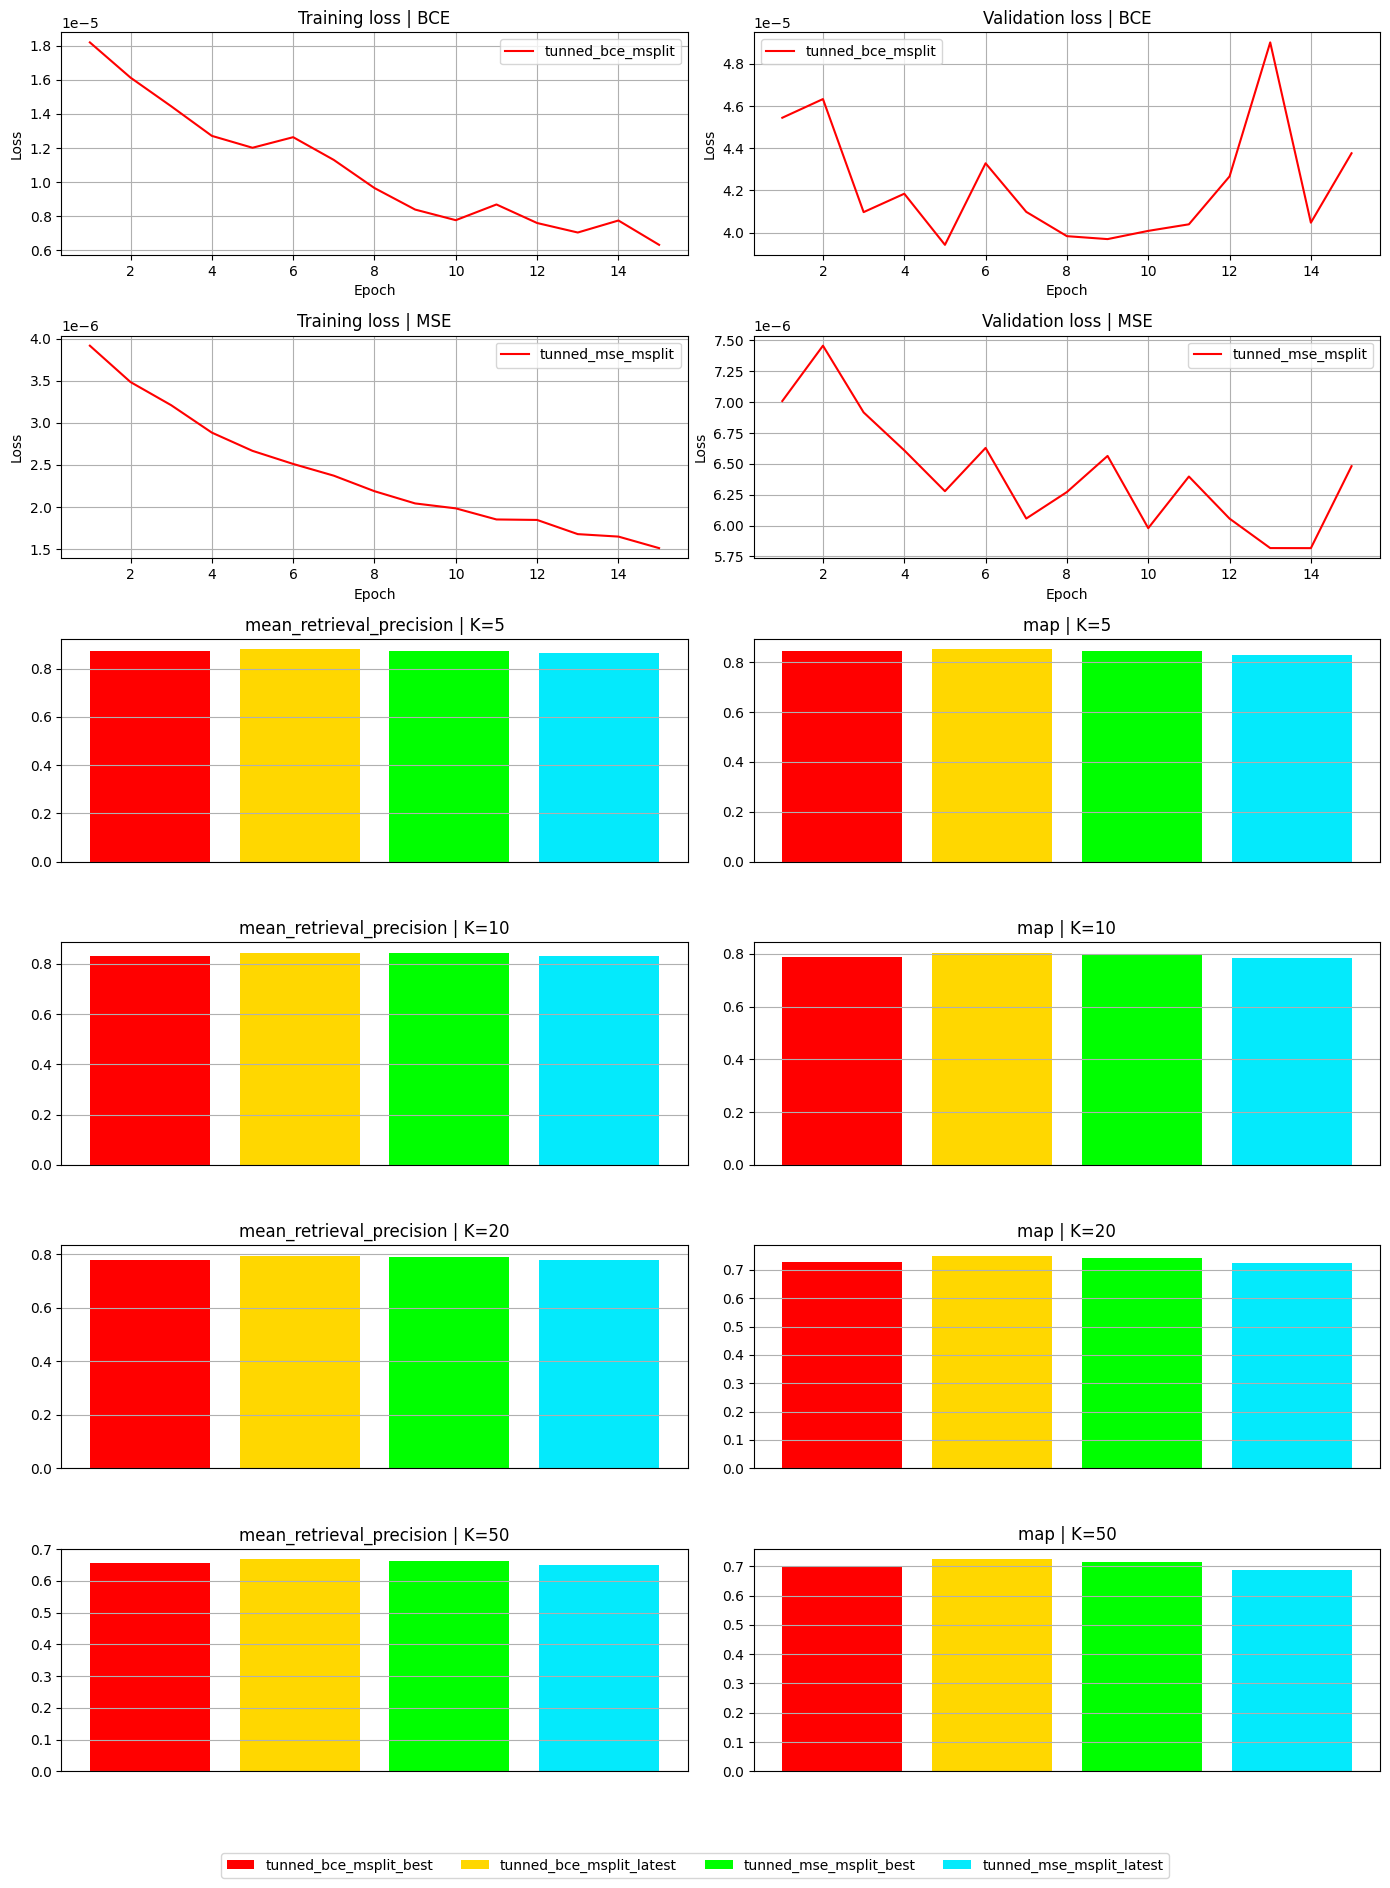

In [79]:
draw_metrics_plots(models_dict, save_path="../data/results/")

## Test interactive

In [80]:
movies_set = [
    (
        "SCI-FI",
        [50, 257, 204, 181],
    ),  # Star Wars, MIB, Back to The Future, Return of the Jedi
    ("CARTOONS", [1, 225, 465, 501]),  # Toy Story, 101 Dalmatians, Jungle Book, Dumbo
    ("STAR TRACK", [222, 228, 380, 449]),  # Star Tracks
    ("PULP FICTION", [56]),  # Pulp Fiction
]

test_model = torch.load("../models/tunned_bce_msplit_best")

In [81]:
show_recommendations(test_model, movies_set)

SCI-FI
Recommendations: ['Toy Story (1995)', 'Heat (1995)', 'Bound (1996)', 'Godfather, The (1972)', 'Secrets & Lies (1996)']

CARTOONS
Recommendations: ['Die Hard: With a Vengeance (1995)', 'Full Monty, The (1997)', 'Mimic (1997)', 'Air Bud (1997)', 'Event Horizon (1997)']

STAR TRACK
Recommendations: ['Toy Story (1995)', 'Everyone Says I Love You (1996)', "Schindler's List (1993)", 'Four Weddings and a Funeral (1994)', 'Forrest Gump (1994)']

PULP FICTION
Recommendations: ['Toy Story (1995)', 'U Turn (1997)', 'Cold Comfort Farm (1995)', 'Cop Land (1997)', 'G.I. Jane (1997)']

